In [1]:
import numpy as np
import niio
import fragmenter as frag

from sklearn.preprocessing import Normalizer

import pandas as pd

import os

In [30]:
subject_file = '/mnt/parcellator/parcellation/parcellearning/Data/SubjectList.txt'
with open(subject_file, 'r') as insubj:
    subjects = insubj.readlines()
subjects = [x.strip() for x in subjects]

region_file = '/mnt/parcellator/parcellation/parcellearning/Data/Labels/Desikan/regions.txt'
with open(region_file, 'r') as inreg:
    regions = inreg.readlines()
regions = [x.strip() for x in regions]

In [ ]:
dDir = '/mnt/parcellator/parcellation/parcellearning/Data/'
N = Normalizer()
for subj in subjects:
    
    lab_file = '{:}Labels/Desikan/{:}.L.aparc.32k_fs_LR.label.gii'.format(dDir, subj)
    surface_file = '{:}Surfaces/{:}.L.midthickness.32k_fs_LR.acpc_dc.surf.gii'.format(dDir, subj)
    
    if os.path.exists(lab_file):
        R = frag.RegionExtractor.Extractor(lab_file)
        L = niio.loaded.load(lab_file)
        region_map = R.map_regions()
    
        for reg in regions:

            conn_file = '{:}Connectopy/Regional/{:}/{:}/{:}.L.{:}.2.brain.Evecs.func.gii'.format(dDir, subj, reg, subj, reg)
            vect_file = '{:}Connectopy/Regional/{:}/{:}/{:}.L.{:}.2.brain.GradientVectors.func.gii'.format(dDir, subj, reg, subj, reg)
            print(vect_file)
            reg_inds = region_map[reg]

            if os.path.exists(conn_file) and os.path.exists(surface_file) and os.path.exists(vect_file):

                vect = niio.loaded.load(vect_file)
                conn = niio.loaded.load(conn_file)
                conn_inds = np.where(conn[:, 0] != 0)[0]
                
                overlap = np.asarray(list(set(conn_inds).intersection(set(reg_inds))))
                
                vects = vect[overlap, :]
                
                for i in np.arange(5):
                    
                    v = vects[:, (i*3):((i*3)+3)]
                    normed = N.fit_transform(v)
                    
                    
                    data = {'x': normed[:, 0],
                            'y': normed[:, 1],
                            'z': normed[:, 2]}
                    df = pd.DataFrame(data)
                    oFile = '{:}Connectopy/Regional/{:}/{:}/{:}.L.{:}.2.brain.E{:}.GradientVector.csv'.format(dDir, subj, reg, subj, reg, (i+1))
                    df.to_csv(oFile, header=True, index=False)

In [2]:
[V, F] = niio.loaded.loadSurf('/mnt/parcellator/parcellation/parcellearning/Data/Surfaces/285345.L.midthickness.32k_fs_LR.acpc_dc.surf.gii')

In [67]:
S = adj.SurfaceAdjacency(vertices=V, faces=F)
S.generate()

In [68]:
from surface_utilities import adjacency as adj
import networkx as nx

In [69]:
G = nx.from_dict_of_lists(S.adj)
la = nx.linalg.laplacian_matrix(G)

In [80]:
la = la.astype('float32')

In [81]:
[w, v] = scipy.sparse.linalg.eigsh(la, k=6)

In [59]:
V1 = np.row_stack([V[F[:, 0],:],
                         V[F[:, 0],:],
                         V[F[:, 1],:],
                         V[F[:, 1],:],
                         V[F[:, 2],:],
                         V[F[:, 2],:]])

V2 = np.row_stack([V[F[:, 1],:],
                         V[F[:, 2],:],
                         V[F[:, 0],:],
                         V[F[:, 2],:],
                         V[F[:, 0],:],
                         V[F[:, 1],:]])

F1 = np.concatenate([F[:, 0], F[:, 0], F[:, 1], F[:, 1], F[:, 2], F[:, 2]])
F2 = np.concatenate([F[:, 1], F[:, 2], F[:, 0], F[:, 2], F[:, 0], F[:, 1]])
stackF = np.column_stack([F1, F2])

D = V1-V2
sq = D**2
s = np.sqrt(sq.sum(1))

In [62]:
dists = np.zeros((32492, 32492))
dists[stackF[:, 0], stackF[:, 1]] = s

In [63]:
D = dists.sum(1)

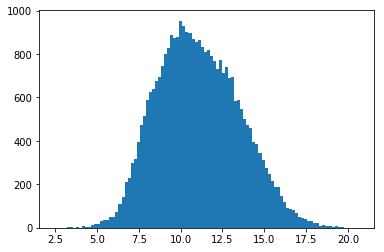

In [88]:
plt.hist(D, 100);

In [19]:
sps_data = np.concatenate([-1*s, D])

In [21]:
Fstack = np.row_stack([stackF, np.column_stack([np.arange(32492), np.arange(32492)])])

In [23]:
import scipy

In [24]:
from scipy import sparse

In [83]:
L = sparse.csr_matrix((sps_data, (Fstack[:, 0], Fstack[:, 1])), shape=(32492, 32492))

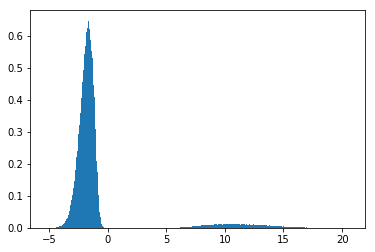

In [89]:
plt.hist(sps_data, 500, density=True);

In [84]:
[w, v] = sparse.linalg.eigsh(L, k=6)

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

In [86]:
niio.write.save(v, '/mnt/home/keschenb/Desktop/Test.Eigenvectors.func.gii', 'CortexLeft')